In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Load the dataset
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Basic cleaning
    df['question'] = df['question'].str.lower()
    df['answer'] = df['answer'].str.lower()

    # Remove special characters and extra whitespace
    df['question'] = df['question'].str.replace(r'[^\w\s]', '')
    df['question'] = df['question'].str.strip()

    # Drop rows with missing values in 'question' column
    df.dropna(subset=['question'], inplace=True) # Added line to drop NaN values

    return df

In [ ]:
def extract_bert_features(texts):
    # Load BERT tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')

    features = []

    for text in texts:
        # Tokenize and encode text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            # Use [CLS] token embedding as feature vector
            embedding = outputs.last_hidden_state[:, 0, :].numpy()

        features.append(embedding[0])

    return np.array(features)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def generate_topics(df):
    # Create document-term matrix
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(df['question'])

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda_output = lda.fit_transform(doc_term_matrix)

    # Assign dominant topic to each question
    df['topic'] = lda_output.argmax(axis=1)

    return df, vectorizer, lda

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def train_models(X_train, X_test, y_train, y_test):
    # Initialize models
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb_model = XGBClassifier(random_state=42)

    # Train models
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Evaluate models
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)

    print("Random Forest Performance:")
    print(classification_report(y_test, rf_pred))
    print("\nXGBoost Performance:")
    print(classification_report(y_test, xgb_pred))

    return rf_model, xgb_model

In [ ]:
import shap

def interpret_model(model, X_test):
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Plot feature importance
    shap.summary_plot(shap_values, X_test)

In [ ]:
def predict_mental_health(question, model, vectorizer, bert_tokenizer, bert_model):
    # Preprocess question
    processed_question = preprocess_text(question)

    # Extract BERT features
    bert_features = extract_bert_features([processed_question])

    # Make prediction
    prediction = model.predict(bert_features)

    return prediction

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       121
           1       0.96      0.94      0.95       185
           2       1.00      0.99      0.99        72
           3       0.93      0.97      0.95       177
           4       0.95      0.96      0.96       148

    accuracy                           0.96       703
   macro avg       0.97      0.96      0.97       703
weighted avg       0.96      0.96      0.96       703


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       121
           1       0.95      0.93      0.94       185
           2       1.00      0.99      0.99        72
           3       0.97      0.97      0.97       177
           4       0.95      0.96      0.95       148

    accuracy                           0.96       703
   macro avg       0.97      0.97      0.97       703
weighted avg       0.96     

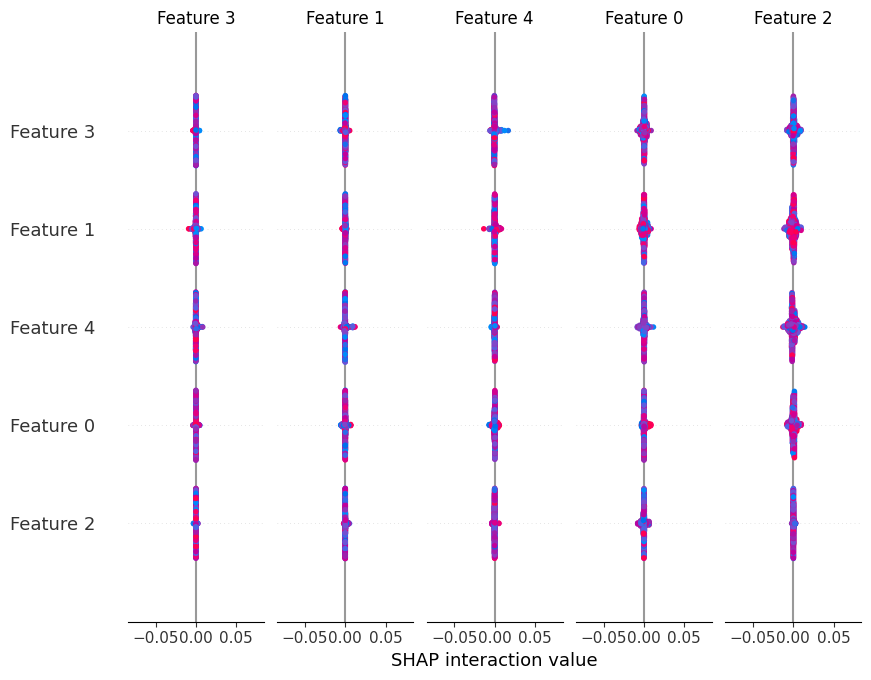

Models saved successfully!


In [ ]:
import joblib

def save_models(rf_model, vectorizer, lda):
    """Saves the trained models to disk.

    Args:
        rf_model: The trained RandomForestClassifier model.
        vectorizer: The CountVectorizer used for text preprocessing.
        lda: The LatentDirichletAllocation model.
    """
    joblib.dump(rf_model, 'rf_model.pkl')
    joblib.dump(vectorizer, 'vectorizer.pkl')
    joblib.dump(lda, 'lda_model.pkl')
    print("Models saved successfully!")

def main():
    # Load and preprocess data
    df = load_and_preprocess_data(r"/content/drive/MyDrive/datasets/split_mental_health.csv")

    # Generate topics and labels
    df, vectorizer, lda = generate_topics(df)

    # Extract BERT features
    features = extract_bert_features(df['question'].tolist())

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, df['topic'], test_size=0.2, random_state=42
    )

    # Train and evaluate models
    rf_model, xgb_model = train_models(X_train, X_test, y_train, y_test)

    # Interpret best model
    interpret_model(rf_model, X_test)

    # Save models
    save_models(rf_model, vectorizer, lda)

if __name__ == "__main__":
    main()